In [1]:
import os 
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils 
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
file = '../../data/data_model/data_sound.pickle'

In [3]:
import pickle 

with open(file, 'rb') as handle:
    data = pickle.load(handle)
    
df = pd.read_csv('../../data/filename_train_test.txt',delimiter='\t',header=None)
df.columns=['file','train_test_split']

In [4]:
X = data['feature']
label = data['label']
label = label.merge(df,on='file',how='left')

In [5]:
label.label.value_counts()

0    3642
2    1864
1     886
3     506
Name: label, dtype: int64

In [6]:
with open('test.npy', 'wb') as f:
    np.save(f, data['feature'])
label.to_csv('label_data.csv')

In [7]:
X = np.reshape(X, (*X.shape,1))

In [8]:
index_train= np.where(label.train_test_split == 'train')[0]
index_test = np.where(label.train_test_split == 'test')[0]

In [9]:
X_train = X[index_train,:]
X_test = X[index_test,:]
y_train = label.loc[label['train_test_split'] == 'train','label'].to_numpy()
y_test = label.loc[label['train_test_split'] == 'test','label'].to_numpy()

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4142, 201, 646, 1) (4142,)
(2756, 201, 646, 1) (2756,)


In [12]:
#import pickle 
#X = {'X_train': X_train,
#     'y_train':y_train,
#     'X_test': X_test,
#     'y_test':y_test}
#file = '../../data/data_model/data_DL.pickle'
#with open(file, 'wb') as handle:
#    pickle.dump(X, handle)

In [10]:
del X

<h1> Vizualization sample <h1>

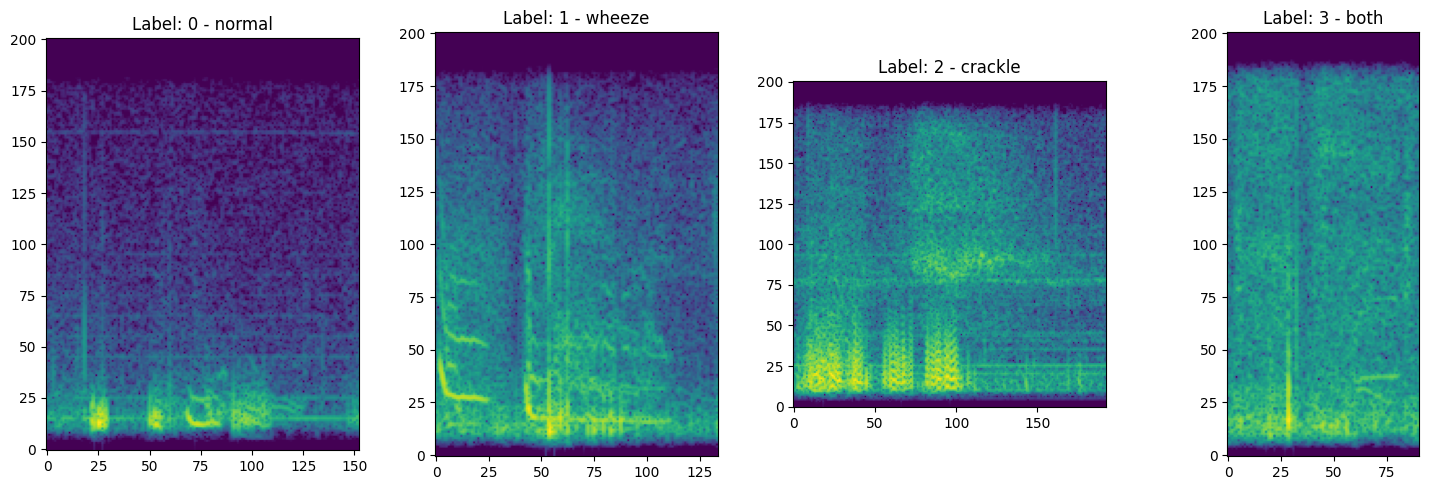

In [11]:
classes = [0,1,2,3]
description = ['normal','wheeze','crackle','both']

f,axes = plt.subplots(1,4,figsize=(15,5))
axes = axes.flatten()
for ax,classes,description in zip(axes,classes,description):
    index_classes_sample = np.where(y_train == classes)[0]
    index_classes_sample = np.random.choice(index_classes_sample)
    index_padding = np.where(X_train[index_classes_sample,1,:]==0)[0][0]
    ax.imshow(X_train[index_classes_sample,:,:index_padding,0])
    ax.invert_yaxis()
    ax.autoscale(True)
    ax.set_title('Label: {} - {}'.format(classes, description))
plt.tight_layout()
plt.subplots_adjust()

<h1> Deep Learning Model<h1>

In [13]:
input_shape = X_train.shape[1:]
n_classes= 4
print(input_shape,n_classes)
filter_size = 3
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=filter_size,
                    input_shape=input_shape, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=256, kernel_size=filter_size,
                    input_shape=input_shape, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=512, kernel_size=filter_size,
                    input_shape=input_shape, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(4, activation = 'softmax'))

opt = tf.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['acc'])

(201, 646, 1) 4


/Users/bastienorset/Documents/git/respiratory_sound/.venv/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
from keras import backend as K
from keras import optimizers

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

history = model.fit(X_train,
          y_train,
          batch_size=25,
          epochs=15,
          validation_data=(X_test, y_test))

Epoch 1/15


2022-10-25 17:17:38.104836: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


104/166 [=================>............] - ETA: 13:05 - loss: 1.2595 - acc: 0.4765

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
print("Evaluate model on test data")
results = model.evaluate(X_test, v)
print("test loss, test acc:", results)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict = model.predict(X_test)
y_predict = np.argmax(y_predict,axis=1)
confusion_matrix(y_test, y_predict)

In [ ]:
print(classification_report(y_test, y_predict, target_names=description))